# 연습문제 2. Deep Learning 모델 HyperParameter 튜닝하기

In [ ]:
!pip install bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable

from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", device)

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using Device: cuda


In [ ]:
cancer = load_breast_cancer()

In [ ]:
# DataFrame으로 만들기
x_data = pd.DataFrame(cancer.data, columns = cancer.feature_names)
y_data = pd.DataFrame(cancer.target)

x_data = (x_data - x_data.mean()) / x_data.std()

x_data, x_test, y_data, y_test =  train_test_split(x_data, y_data, test_size=0.1, shuffle=False)
x_train, x_val, y_train, y_val =  train_test_split(x_data, y_data, test_size=0.1, shuffle=True, stratify = y_data, random_state=34)

In [ ]:
def make_torch(x):
    return  torch.from_numpy(x.to_numpy().astype(np.float32))

trainset = TensorDataset(make_torch(x_train), make_torch(y_train))
valset = TensorDataset(make_torch(x_val), make_torch(y_val))
testset = TensorDataset(make_torch(x_test), make_torch(y_test))

In [ ]:
class MLP(nn.Module):
    def __init__(self, dropout = 0.5):
        super(MLP, self).__init__()
        self.block1 = nn.Sequential(
            nn.Linear(30, 128),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.block2 = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.block3 = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.output = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        y = self.output(x)
        return self.sigmoid(y)

In [ ]:
from bayes_opt import BayesianOptimization
def evaluate(epochs, batch_size, learning_rate, dropout):
    epochs = int(epochs)
    batch_size = int(batch_size)
    
    
    trainloader = DataLoader(dataset = trainset, batch_size = batch_size, shuffle = True, num_workers = 2)
    valloader = DataLoader(dataset = valset, batch_size = batch_size, shuffle = True, num_workers = 2)
    testloader = DataLoader(dataset = testset, batch_size = batch_size, shuffle = True, num_workers = 2)
    
    model = MLP(dropout).to(device)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
    criterion = nn.BCELoss()
    
    for epoch in range(1, epochs+1):
        loss_value = 0
        for step, (x, y) in enumerate(trainloader):
            model.train()
            x = x.to(device)
            y = y.to(device)

            pred = model(x)

            loss = criterion(pred, y)
            loss_value += loss.item()
            optimizer.zero_grad()

            loss.backward()
            optimizer.step()
        correct = 0
        total = 0
        for step, (x, y) in enumerate(valloader):
            
            model.eval()
            with torch.no_grad():
                x = x.to(device)
                pred = model(x)
                correct += (pred.detach().cpu() == y).sum()
                total += len(y)
            accuracy = correct * 100 / total
    return accuracy


mlp_bo = BayesianOptimization(evaluate, {'epochs':(5,10),
                                           'batch_size':(100,500),
                                           'learning_rate':(0.01, 0.1),
                                           'dropout':(0.1,0.7)})
mlp_bo.maximize(init_points=3, n_iter=5, acq='ei')

|   iter    |  target   | batch_... |  dropout  |  epochs   | learni... |
-------------------------------------------------------------------------


<ipython-input-8-c6130b9111d7>:49: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  mlp_bo.maximize(init_points=3, n_iter=5, acq='ei')


| 1         | 94.23     | 204.5     | 0.5857    | 7.834     | 0.07301   |
| 2         | 38.46     | 367.4     | 0.5489    | 8.569     | 0.09327   |
| 3         | 13.46     | 131.1     | 0.3247    | 8.547     | 0.01513   |
| 4         | 96.15     | 205.5     | 0.6104    | 8.255     | 0.06427   |
| 5         | 1.923     | 242.5     | 0.7       | 10.0      | 0.01      |
| 6         | 98.08     | 500.0     | 0.5403    | 9.601     | 0.09131   |
| 7         | 38.46     | 479.9     | 0.3777    | 8.359     | 0.08425   |
| 8         | 1.923     | 179.6     | 0.7       | 10.0      | 0.01      |


In [ ]:
epochs = 8
batch_size = 205
learning_rate = 0.06427 
dropout = 0.6104

trainloader = DataLoader(dataset = trainset, batch_size = batch_size, shuffle = True, num_workers = 2)
valloader = DataLoader(dataset = valset, batch_size = batch_size, shuffle = True, num_workers = 2)
testloader = DataLoader(dataset = testset, batch_size = batch_size, shuffle = True, num_workers = 2)

model = MLP(dropout).to(device)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
criterion = nn.BCELoss()
loss_list = []

for epoch in range(1, epochs+1):
    loss_value = 0
    for step, (x, y) in enumerate(trainloader):
        model.train()
        x = x.to(device)
        y = y.to(device)

        pred = model(x)

        loss = criterion(pred, y)
        loss_value += loss.item()
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()
    loss_list.append(loss_value)
    
    correct = 0
    total = 0
    for step, (x, y) in enumerate(valloader):

        model.eval()
        with torch.no_grad():
            x = x.to(device)
            pred = model(x)
            correct += (pred.detach().cpu() == y).sum()
            total += len(y)
        accuracy = correct * 100 / total
    print("Epoch : ", epoch, ', Loss : ', loss.item(), 'Accuracy', accuracy.item() , '%')

Epoch :  1 , Loss :  10.446486473083496 Accuracy 61.53845977783203 %
Epoch :  2 , Loss :  1.488213300704956 Accuracy 86.53845977783203 %
Epoch :  3 , Loss :  8.2781343460083 Accuracy 88.46154022216797 %
Epoch :  4 , Loss :  6.0 Accuracy 92.30769348144531 %
Epoch :  5 , Loss :  4.000000953674316 Accuracy 96.15384674072266 %
Epoch :  6 , Loss :  8.0 Accuracy 96.15384674072266 %
Epoch :  7 , Loss :  4.0 Accuracy 96.15384674072266 %
Epoch :  8 , Loss :  12.0 Accuracy 96.15384674072266 %


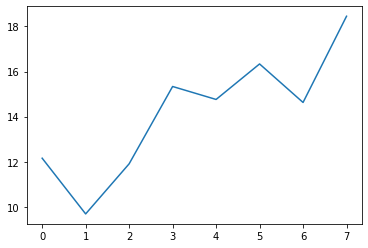

In [ ]:
plt.plot(loss_list)

In [ ]:
with torch.no_grad():
    model.eval()
    pred = []
    for x, y in valset:
        x = x.to(device)
        pred.append(int(model(x).detach().cpu().item()))
accuracy = accuracy_score(y_val, pred)
print('Validation Accuracy: %.2f%%' % (accuracy * 100.0))

Validation Accuracy: 98.08%


In [ ]:
with torch.no_grad():
    model.eval()
    pred = []
    for x, y in testset:
        x = x.to(device)
        pred.append(int(model(x).detach().cpu().item()))
accuracy = accuracy_score(y_test, pred)
print('Test Accuracy: %.2f%%' % (accuracy * 100.0))

Test Accuracy: 96.49%
